In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)
plt.style.use("ggplot")

### 1) Коэффициенты ассоциации и контингенции для таблиц 2x2

In [35]:
def contingency2x2_coefficients(data, return_coefficients = False):
    
    if isinstance(groupped, pd.core.frame.DataFrame):
        data = data.to_numpy()
        
    K_a = (data[0, 0] * data[1, 1] - data[0, 1] * data[1, 0]) / (data[0, 0] * data[1, 1] + data[0, 1] * data[1, 0])
    K_k = (data[0, 0] * data[1, 1] - data[0, 1] * data[1, 0]) / ((data[0, 0] + data[0, 1]) * (data[0, 1] + data[1, 1]) * (data[0, 0] + data[1, 0]) * (data[1, 0] + data[1, 1])) ** (0.5)
    
    print("Коэффициент ассоциации: ", K_a)
    print("Коэффициент контингенции: ", K_k)
    
    if (K_a >= 0.5) or (K_k >= 0.3):
        print("Связь достаточно сильная между двумя признаками")
    else:
        print("Связь слабая между двумя признаками")
        
    if return_coefficients:
        return (K_a, K_k)

In [33]:
data = {"Да": [40, 10], "Нет": [143, 101]}
groupped = pd.DataFrame(data, index = ["Женщины", "Мужчины"])
groupped.index.name = "Пол"
groupped.columns.name = "Депрессия"

groupped

Депрессия,Да,Нет
Пол,,
Женщины,40,143
Мужчины,10,101


In [36]:
contingency2x2_coefficients(groupped) 

Коэффициент ассоциации:  0.47714808043875684
Коэффициент контингенции:  0.1657958126346275
Связь слабая между двумя признаками


### 2) Критерий Хи-квадрат и другие статистики для таблиц сопряжённости

In [31]:
def plot_chi2_test(data, yets_correction = True, return_statistics = False, only_coefficients = False, fisher_test = True):
    '''
    Вычисляет Хи-квадрат статистику для проверки гипотезы о взаимосвязи двух номинальных переменных, и на основе этой статистики вычисляет:
       1. Фи коэффициент (только для таблица 2x2) (Принимает значения от 0 до 1, где 0 - отсутствие связи, 1 - сильная связь)
       2. Коэффициент сопряжённости Пирсона 
       2. Коэффициент сопряжённости Чупрова
       3. Коэффициент сопряжённости Крамера (Совпадает с Фи коэффициентом, если таблица имеет размер 2x2) (Принимает значения от 0 до 1, где 0 - отсутствие связи, 1 - сильная связь)
       
       Также может вычислять статистику точного теста Фишера для таблиц 2x2 (Рекомендуется, если частот в любой из ячеек меньше 5)
       
    Параметры
    ----------
    data: array_like
        Принимает на вход массив типа Numpy или Pandas
             
    yets_correction: bool
        Испольовать ли поправку Йетса (Рекомендуется, если частот в любой из ячеек больше 5, но меньше 10)
       
    return_statistics: bool
        Возвращать ли коэффициент Хи-квадрат, p уровень значимости, число степеней свободы и таблицу ожидаемых частот (chi2, p, dof, ex)
       
    only_coefficients: bool
        Выводит только коэффициенты связи, без отрисовки графика
       
    fisher_test: bool
        Применять ли тест Фишера для данной таблицы (работает только если таблица имеет размер  2x2)
    '''
    
    if isinstance(groupped, pd.core.frame.DataFrame):
        data = data.to_numpy()
    
    chi2, p, dof, ex = stats.chi2_contingency(data, correction = yets_correction)
    margins_sum = stats.contingency.margins(data)
    summed = margins_sum[0].sum()
    
    if not only_coefficients:
        chi2_critical = stats.chi2.ppf(0.95, df = (data.shape[0] - 1) * (data.shape[1] - 1))
        
        chi2_arange = np.arange(0, chi2_critical + 2, 0.01)
        chi2_vals = stats.chi2.pdf(chi2_arange, df = (data.shape[0] - 1) * (data.shape[1] - 1))
        
        plt.plot(chi2_arange, chi2_vals, label = "Chisquare distribution", color = "k")
        plt.axvline(chi2, color = "b", label = "Chisquare-statistical")
        plt.axvline(chi2_critical, color = "r", label = "Chisquare-critical", linestyle = "dashed")
        plt.ylim(0, chi2_vals[1:].max())
        
        plt.fill_between(np.arange(chi2, chi2_critical + 2, 0.01), stats.chi2.pdf(np.arange(chi2, chi2_critical + 2, 0.01), df = (data.shape[0] - 1) * (data.shape[1] - 1)), color = "dodgerblue")
        
        if p <= 0.05:
            print("Скорее всего, признаки взаимосвязаны. P-value: {}".format(p))
        else:
            print("Скорее всего, признаки не взаимосвязаны. P-value: {}".format(p))
            
        if ((data.shape[0] == 2) and (data.shape[1] == 2)) and fisher_test:
            oddsratio, p_fisher = stats.fisher_exact(data)
            
            print("P-value точного теста Фишера: ", p_fisher)
            
        print("Хи-квадрат статистика: ", chi2)
        print("Хи-квадрат критический: ", chi2_critical)
        print("-"*10)
    
    Pirson_coefficient = (chi2  / (chi2 + summed)) ** (0.5)
    Chuprov_coefficient = (chi2 / (summed * ((data.shape[0] - 1) * (data.shape[1] - 1)) ** (0.5)))
    
    if (data.shape[0] == 2) and (data.shape[1] == 2):
        phi_coefficient = (chi2 / summed) ** (0.5)
        print("Соотношение шансов: ", (data[0, 0] * data[1, 1]) / (data[0, 1] * data[1, 0]))
        print("Фи коэффициент: ", phi_coefficient)
    else:
        Cramer_coefficient = ((chi2 / summed) / (np.min([data.shape[0] - 1, data.shape[1] - 1]))) ** (0.5)
        print("Коэффициент сопряжённости Крамера: ", Cramer_coefficient)
    

    
    print("Коэффициент сопряжённости Пирсона: ", Pirson_coefficient)
    print("Коэффициент сопряжённости Чупрова: ", Chuprov_coefficient)

Скорее всего, признаки взаимосвязаны. P-value: 0.00730317939152859
P-value точного теста Фишера:  0.004018099389189503
Хи-квадрат статистика:  7.196846750001813
Хи-квадрат критический:  3.841458820694124
----------
Соотношение шансов:  2.825174825174825
Фи коэффициент:  0.15645788755520593
Коэффициент сопряжённости Пирсона:  0.15457737111105882
Коэффициент сопряжённости Чупрова:  0.02447907057823746


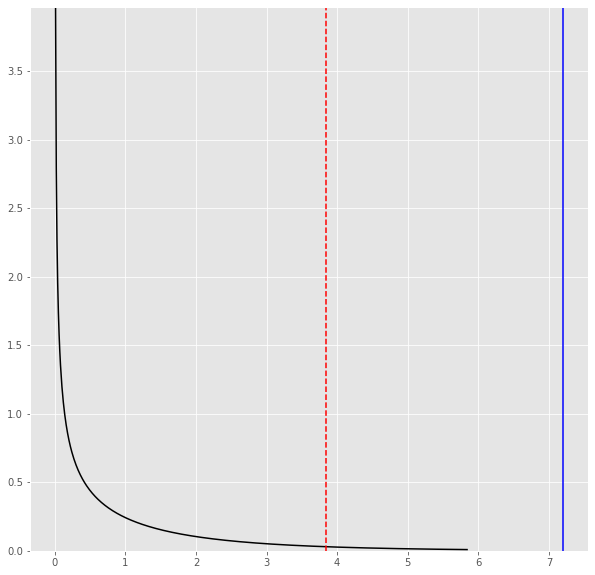

In [38]:
plot_chi2_test(groupped, yets_correction=True)